## IMDB Web Scrapper

William Egan (Responsible for Submissions) - wve204 | Tinatin Nikvashvili - tn709 | <br> Nathan Griffin - nlg297 | Khasi Jamieson - kmj426

### Abstract

We have constructed a web scraper that pulls instances from IMDB of movies and stores them in a dataframe. This algorithm can be modified to pull movies based on genre, date released, language used, and many other metrics. The program gathers a wide range of features for each film, including financial and personnel data as well as information about the movie itself. This collection of features allows data scientists to pursue a wide range of data mining and analytical work, as we demonstrate in this notebook.

### Motivation

IMDB offers downloadable datasets, but all of these are limited in scope (link to said datasets here: https://www.imdb.com/interfaces/). None of these contain any more than 8 features, and it would be complicated data munging task in and off itself to merge all of these into a single dataframe. There are also a limited number of features offered by these, which does not include financial information about the film, which is a feature of great interest for most data-driven business problems relating to film.

These limited channels of access inspired us to employ our python skills to develop a web scraper for pulling exactly the information we want from webpages for films. Along with determining all the features we want, we can also choose what subset of films we would like to pull from based off of IMDB's own advanced search tool. A program that can effectively pull data sets of movies with any desired features or movie type would be useful for anyone who wants to perform data analysis on films. We believe the particular features we have chosen to be especially interesting to perform analysis and data mining methods on. 

### Step 1: Extract urls from IMBD search
[IMDB Search](https://www.imdb.com/search/title/)


The first step in this application is to take an input search (link above) and return a list of urls: one for each movie that satisfies those parameters. To implement this function, we will need the help of a few libraries: BeautifulSoup, urllib, and webbrowser (for debugging). We first entered a search into IMDB's advanced search tool. In particular, we entered a search for all English-language feature films released in 2018. We notice that the total number of movies that match the search is listed at the top, and that there are 50 movies per page. Therefore, we know two important variables right off the bat: how many urls we expect to return and how many webpages we will have to iterate over to get them all. 

The function, therefore, will begin by creating a BeautifulSoup object (i.e. a parsed HTML file) of the search url by opening the search url with urllib. Right away, we extract the total number of films returned from this query using the find_all method in BeautifulSoup, replacing the comma with nothing, and converting the resulting string to an integer. We then print the number for the users reference. From here, we need to understand how to move through each page of the query. By looking at page two, we see that it is, fortunately, pretty simple. By just appending "&start=n" where n is any number (1 in our case), to the search url, we can look at a page with 50 entries, starting at the nth entry. Getting a list of these numbers is a simple list comprehension. 

From there, we iterate through each of these urls, creating a new BeautifulSoup object each time, and grabbing all links from the page using the get and findall methods. From the list of links, we look for a specific string 'title/tt' that corresponds to webpages for movie profiles, add it to the final url list, checking to make sure it is not already there. Once it iterates through each page and adds all urls, a test is run to ensure that the number of movies in the search matches the length of the final url list. 

There was an issue initially with the length of the list exceeding the number of movies in the search, so some debugging was required.  In some cases, there was only one extra link, while in others there was more than 100. The webbrowser library was used to open every 50 links to see which page was adding extra information. In hindsight, a more efficient option may have been to print out how many items were added to the list in each loop and look for values over 50. Regardless, the issue was that some movies had a link to sequels/prequels included with them. This did not show up on the webpage, but was included in the html file. Furthermore, each valid url was listed 3 seperate times, one with an extra directory in the url. Since these were the only title links with a length of 4 when split on '/', that is ultimately how we filter out for valid urls. This method also avoids checking for duplicate values in the list twice for a better optimized runtime.

In [1]:
#Import relevant libraries
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import requests
from time import sleep
from random import randint
import pandas as pd
import numpy as np
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [1]:
def url_extractor(search_url):
    '''Return a list of urls for all movies from an IMDB search.
    
    Input
    =====
    search_url(String): url from executed IMDB search.
    
    Output
    =====
    url_list(List): list of all urls for movies that satisfied search params.
    
    '''
    #setting up initial BeautifulSoup object from websearch 
    init_resp = urllib.request.urlopen(search_url)
    init_soup = BeautifulSoup(init_resp, 'html.parser')
    #extract the number of films that the query returned. Used to confirm at end and generate each url 
    number_of_films = int(str(init_soup.find_all('div', class_='desc')[0].find_all('span')[0]).split(' ')[2].replace(',',''))
    print(number_of_films)
    #each page has 50 movies, so setting up a list to iterate through the pages, set up blank list to store final urls
    iterative_urls = [i for i in range(1,number_of_films, 50)]
    url_list = []
    #loop through the 50-spaced interger values to generate entire list of needed search urls 
    for i in iterative_urls:
        # set url
        url = search_url + '&start=' + str(i)
        #set up the BeautifulSoup object for this specific page of the search
        resp = urllib.request.urlopen(url)
        soup = BeautifulSoup(resp, 'html.parser')
        #generating list of all links on this page
        links = [a.get('href') for a in soup.find_all('a', href=True)]
        # printing out where we are in the query to monitor efficiency
        print('Running query from {} to {}'.format(i, i+49))
        # checking each link in each search page for title/tt keyword
        for link in links:
            if 'title/tt' in link:
                #when the length is 4 of the split title url, that means it is part of query 
                #when the length is 3, it means that the movie is ancillary to the actual search (prequel/sequel)
                if len(link.split('/')) == 4:
                # format the resulting url in the correct manner and appending it to final list 
                    title_link = 'https://www.imdb.com' + '/' + link.split('/')[1] + '/' + link.split('/')[2] + '/?ref_=adv_li_i'
                    if not title_link in url_list:
                        url_list.append(title_link)
                    else: 
                        continue 
                else: 
                    continue
            else:
                continue
    # Final test to make sure that the length of query equals the length of returned list and returning the final list
    if len(url_list) == number_of_films:
        print('All urls have been extracted successfully')
    else: 
        print('WARNING: The number of films in this query was {}, but {} urls were returned'.format(number_of_films, len(url_list)))
    return(url_list)

### Step 2: Web Scraper

In this part of the project we use web scraping to gather data about all of the query result movies from IMDB's web page in a format that will be usable for analysis. In particular, we want to collect information about movie title, genres, country, language, filming location, production company, runtime, budget information, release date, directors, writers, stars acting in the movie, rating, review count and finally mpaa ratings.

Since our goal is to scrape information from multiple webpages with the same html structure, first we had to understand the structure of a movie profile page on IMDB's website. To do this, we used Chrome's Developer tools to inspect the structure of only one page. By right clicking and hitting inspect you can see the HTML line that corresponds to the part of webpage you clicked on. There are many HTML lines nested within each tag, and for each feature we found unique identifiers of information we wanted to extract. 

Then, in order to extract the contents of the webpage, we download the pages we wanted to scrape by using the request library. The library makes a get request to IMDB's server and downloads the HTML contents of a given web page. After we wun the request using requests.get method, we get back a response object that has a status_code, which equals 200 if the page is downloaded successfully. This enables us to include error catching into our code and return a warning whenever web pages are not downloaded successfully (the case when status_code does not equal 200).  

BeautifulSoup has a functionality that allows for parsing through captured HTML data based on the HTML tags. HTML also has class properties, that give HTML elements names and makes it easier to identify relevant text during scraping. One element can have multiple classes. We can extract the relevant information from tags by specifying class using find_all method to find all instances of a tag in a webpage. For example in line 39 we search for any div tag that has a class of 'see-more inline canwrap'. Find_all returns a list, therefore we used list indexing to extract relevant text by using text method.  Additionally, as all tags are nested, we had to move through levels to get to specific text by first selecting all elements at the top level. For example to gather information about genres we first extract text from any div tag that has class being 'see-more inline canwrap' and then extract text for h4 tag with class_ = 'inline'. Once we are able to uniquely identify how to get each piece of information:

* we can loop through multiple urls
* place get requests within the loop for each page
* convert the response's html content to beautiful soup object
* extract all containers from this object by using find_all method, if there is no information than continue to the next variable
* use list indexing to access information
* and save this information into pandas’ dataframe.

At the end of this process, we have a dataframe with each row representing information on each movie scraped and each column corresponding to the variable we scraped. 

One of the issues we had to deal with was not having all of the features present on each web page. For example, not all movies have information about genres, language, writers and etc. Therefore, we used try and except statements to scrape information when present and continue running the code when the information was missing.

In [3]:
def scraper(urls):
    '''Scrape information about movies from imdbs website

    Input
    =====
    urls: list of urls
    
    Output
    ======
    movies: dataframe containning as rows movies we scraped and columns the features scraped
    
    '''
    
    #Create a dataframe to store scraped data in (features as columns)
    features = ['genre_0','genre_1','genre_2', 'genre_3','country','language','filming_locs','production_co','runtime',
    'budget','gross_usa','release','director_0','director_1','rating','star_0','star_1','star_2','star_3','writer_0',
    'writer_1','writer_2','review_count','title','open_week','cumulative', 'mpaa_rating']
    
    #number of rows of data frame = # of movies scraped, # of columns = # of features
    movies = pd.DataFrame(data = np.empty((len(urls), len(features))),
                         columns= features)
    
    #data set is initialized as nan
    movies[:] = np.nan
    
    #create a list of rating we want to collect
    rating_list = ['   G', '   PG', 'PG-13', '   R', 'NC-17', 'Not Rated', 'Unrated', 
                   'TV-Y', 'TV-Y7', 'TV-G', 'TV-PG','TV-14', 'TV-MA']   
    
    count = 1
    #loop through urls and scrape relevant features
    for idx,url in enumerate(urls):
        count += 1
        
        resp = requests.get(url)#request content of the webpage and store in resp

        #Pause the loop but takes a long time
        #sleep(randint(8,15))

        #Error if  status codes is not 200
        if resp.status_code != 200:
            warn('Request: {}; Status code: {}'.format(request, response.status_code))

        soup = BeautifulSoup(resp.text, 'html.parser')#use pythons built in html parser
        
        #collect mpaa ratings
        mpaa = soup.find_all('div', class_ = 'title_wrapper')[0].find_all('div', class_ = 'subtext')[0].text
        for i in rating_list:
            if i in mpaa:
                movies.loc[idx, 'mpaa_rating'] = i
                
        #get all genres
        genres_spec = soup.find_all('div', class_ = 'see-more inline canwrap')
        for i in range(len(genres_spec)):
            if 'Genres' in genres_spec[i].find('h4', class_ = 'inline').text:
                genres = soup.find_all('div', class_ = 'see-more inline canwrap')[i].find_all('a')
                movies.loc[idx,'genre_0'] = genres[0].text
                try:
                    movies.loc[idx,'genre_1']= genres[1].text
                except:
                    pass
                try:
                    movies.loc[idx,'genre_2'] = genres[2].text
                except:
                    pass
                try:
                    movies.loc[idx,'genre_3'] = genres[3].text
                except:
                    pass

        #Get country, language, filming location, production co, budget info variables
        other_specs = soup.find_all('div', class_ = 'txt-block')
        for i in range(len(other_specs)):
            if other_specs[i].find('h4', class_ = 'inline') is None:
                pass
            elif 'Country' in other_specs[i].find('h4', class_ = 'inline').text:
                movies.loc[idx,'country'] = other_specs[i].a.text
            elif 'Language' in other_specs[i].find('h4', class_ = 'inline').text:
                movies.loc[idx,'language'] = other_specs[i].a.text
            elif 'Filming Locations' in other_specs[i].find('h4', class_ = 'inline').text:
                movies.loc[idx,'filming_locs'] = other_specs[i].a.text
            elif 'Production Co' in other_specs[i].find('h4', class_ = 'inline').text:
                movies.loc[idx,'production_co'] =other_specs[i].a.text
            elif 'Runtime' in other_specs[i].find('h4', class_ = 'inline').text:
                movies.loc[idx, 'runtime'] = other_specs[i].time.text
            elif 'Budget' in other_specs[i].find('h4', class_ = 'inline').text:
                try:
                    movies.loc[idx,'budget']= other_specs[i].text
                except: 
                    pass
            elif 'Gross USA' in other_specs[i].find('h4', class_ = 'inline').text:
                try:
                    movies.loc[idx,'gross_usa'] = other_specs[i].text
                except:
                    pass
            elif 'Opening Weekend USA' in other_specs[i].find('h4', class_ = 'inline').text:
                try:
                    movies.loc[idx,'open_week'] = other_specs[i].text
                except:
                    pass
            elif 'Cumulative Worldwide Gross' in other_specs[i].find('h4', class_ = 'inline').text:
                try:
                    movies.loc[idx,'cumulative'] = other_specs[i].text
                except:
                    pass

        #get release date
        try:
            movies.loc[idx,'release'] = soup.find_all('div', class_ = 'subtext')[0].find_all('a', title = "See more release dates")[0].text
        except:
            pass

        #Get director, writer and stars    
        movie_containers = soup.find_all('div', class_ = 'credit_summary_item')
        for i in range(len(movie_containers)):
            if 'Director' in movie_containers[i].find('h4', class_ = 'inline').text:
                movies.loc[idx,'director_0'] = movie_containers[i].find_all('a')[0].text
                try:
                    movies.loc[idx,'director_1']= movie_containers[i].find_all('a')[1].text
                except:
                    pass
            if 'Writer' in movie_containers[i].find('h4', class_ = 'inline').text:
                movies.loc[idx,'writer_0']=movie_containers[i].find_all('a')[0].text
                try:
                    movies.loc[idx,'writer_1']=movie_containers[i].find_all('a')[1].text
                except:
                    pass
                try:
                    movies.loc[idx,'writer_2']=movie_containers[i].find_all('a')[2].text
                except:
                    pass

            if 'Star' in movie_containers[i].find('h4', class_ = 'inline').text:
                movies.loc[idx,'star_0']=movie_containers[i].find_all('a')[0].text
                try:
                    movies.loc[idx,'star_1']=movie_containers[i].find_all('a')[1].text
                except:
                    pass
                try:
                    movies.loc[idx,'star_2']=movie_containers[i].find_all('a')[2].text
                except:
                    pass
                try:
                    movies.loc[idx,'star_3']=movie_containers[i].find_all('a')[3].text
                except:
                    pass

        #Get raitng, review count and the title of the movie
        try:
            movies.loc[idx,'rating']=soup.find_all('span',{'itemprop':'ratingValue'})[0].text
        except:
            pass
        try:
            movies.loc[idx,'review_count']=soup.find_all('span',{'itemprop':'ratingCount'})[0].text
        except:
            pass
        movies.loc[idx,'title']=soup.find_all('title')[0].text
        
        
        if count%100 == 0:
            print('Extracted {}'.format(count)) 
        
        
    return movies

### Step 3: Cleaning the Data

The final step of the project is to clean the data set and prepare it for data analysis. When the data is read in from the scraper, beautiful soup captures other elements, of the html code such as line breaks and tab characters that restricts our ability to interpret our data, which we will refer to as 'bad characters'. Our goal in the cleaning of the data is three fold: All columns in the data frame should be of the appropriate data type with the aforementioned 'bad characters', all place holders/category extenders should be removed, and categorical features encoded when necessary. To do so we break the cleaning process into three functions: 

* `clean_data` 
* `encode_genre`
* `adjust_years`

clean_data has three primary functionalities:
* The first is to remove all bad characters from columns. Numerical information to be cleaned includes the films' runtime, budget, gross_usa earnings, rating out of 10, number of reviews, opening week sales and cumulative earnings. All the numerical columns are cleaned and cast as floats. Title and release date are also cleaned to remove bad characters. 
* The second is to clean place holder variables and Nans. Place holder categorical variables are replaced with an empty string and Nans are filled with zeros. 
* For the the purpose of this analysis, we drop rows that do not have financial data (open_week, cumulative, etc.) since these are key features in our analysis later

We chose to encode the categorical variable of genre. This is done by using the encode_genre function. Based on IMDBs website description, there is a reasonable number of genres to encode, so this is a viable task. We use the get_dummies function in pandas in conjunction with aggregating of genre to create a binary column for each genere label.

The last step in the process is the adjust_years funtion. For the purpose of our analysis we only want the years the movie was released. It is important to note that this procedure can be extended to involve months if there is analysis that requires this.  

In [4]:
def clean_data(df):
     '''Clean dataframe and prepare it for analysis

    Input
    =====
    df: dataframe of scrapped data
    
    Output
    ======
    result: dataframe with 'bad' strings removed and NaNs cleaned
    
    '''
    num_cols = ['runtime', 'budget', 'gross_usa', 'rating', 'review_count', 'open_week', 'cumulative']
    output = df.copy()
    
    # removing all strings from numeric columns 
    for col in num_cols:
        output[col] = (output[col].str.replace('\D+', '')).astype("float64")
        
    # cleaning null/place holder values   
    output = output.drop(['filming_locs'], axis = 1)
    output = output.fillna(0)
    output.replace(to_replace = "See full cast & crew", value = "", inplace = True)
    output.replace(to_replace = "[0-9][0-9]* more credits*", value = "", inplace = True, regex=True)
    
    # removing 'bad' string from title and date (still need to fix datetime)
    output['title'] = output['title'].str[0:-14]
    output['release']
    
    result = output.loc[(output[['budget', 'gross_usa', 'open_week', 'cumulative']] != 0).any(axis = 1)]

    return result

In [5]:
def encode_genre(df):
     '''One Hot encoding of genre categorical entries 

    Input
    =====
    df: dataframe 
    
    Output
    ======
    output: dataframe with genre encoded
    
    '''
    
    # encoding genre as dummie variables
    output = pd.get_dummies(df, prefix_sep='_', columns = ['genre_0', 'genre_1', 'genre_2', 'genre_3'], drop_first=True)

    #retreives all columns with 'genre'
    genre_ls_all = output.filter(like='genre_').columns.tolist()

    # aggregates genre buckets into single bucket
    genre_ls = []
    for item in genre_ls_all:
        if item[9:] not in genre_ls:
            genre_ls.append(item[9:])

    for col in genre_ls:
        output[col] = output.filter(like = col).sum(axis = 1)
        
    for col in genre_ls:
        output[col] = output[col].clip(upper = 1)

    output = output[output.columns.drop(list(output.filter(regex='genre')))]
    
    return output

In [23]:
def adjust_years(df):
    '''Updating release to only contain the year of realeas 

    Input
    =====
    df: dataframe with release year as day, month year
    
    Output
    ======
    output: dataframe with just the release year
    
    '''
    
    
    df = df.reset_index(drop = True)
    year_df = df['release'].str.extract(r'(\b\d{4}\b)')
    year_df.columns = ['Year']
    result = pd.concat([year_df, df.drop(['release'], axis = 1)], axis = 1)
    result = result.fillna(0)
    result['Year'] = result.Year.astype('int')
    
    return result
    

### Execution

In [ ]:
#url = url_extractor('https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2018-03-01')
url = url_extractor('https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2018-12-31&languages=en')m

NOTE: This takes 1.5 hours to run

In [ ]:
movies = scraper(url)

In [32]:
clean_movies = clean_data(movies)

encoded = encode_genre(clean_movies)

df_final = adjust_years(encoded)

df_final

,Year,country,language,production_co,runtime,budget,gross_usa,director_0,director_1,rating,...,Family,Fantasy,History,Music,Musical,Romance,Sci-Fi,Sport,Thriller,War
0,2019,USA,English,Tribeca Productions,209.0,159000000.0,0.0,Martin Scorsese,0,82.0,...,0,0,0,0,0,0,0,0,0,0
1,2019,USA,English,BRON Studios,122.0,55000000.0,332570374.0,Todd Phillips,0,87.0,...,0,0,0,0,0,0,0,0,1,0
2,2019,USA,English,Chernin Entertainment,152.0,97600000.0,94104794.0,James Mangold,0,83.0,...,0,0,0,0,0,0,0,1,0,0
3,2019,UK,English,Heyday Films,136.0,18600000.0,0.0,Noah Baumbach,0,83.0,...,0,0,0,0,0,1,0,0,0,0
4,2019,South Korea,Korean,Barunson E&A,132.0,0.0,19717719.0,Bong Joon Ho,0,86.0,...,0,0,0,0,0,0,0,0,1,0
5,2019,USA,English,Marvel Studios,181.0,356000000.0,858373000.0,Anthony Russo,Joe Russo,85.0,...,0,0,0,0,0,0,1,0,0,0
6,1990,USA,English,Warner Bros.,146.0,25000000.0,46836214.0,Martin Scorsese,0,87.0,...,0,0,0,0,0,0,0,0,0,0
7,1972,USA,English,Paramount Pictures,175.0,6000000.0,134966411.0,Francis Ford Coppola,0,92.0,...,0,0,0,0,0,0,0,0,0,0
8,1947,USA,English,Liberty Films (II),130.0,3180000.0,0.0,Frank Capra,0,86.0,...,1,1,0,0,0,0,0,0,0,0
9,1988,USA,English,Twentieth Century Fox,132.0,28000000.0,83519093.0,John McTiernan,0,82.0,...,0,0,0,0,0,0,0,0,1,0


### Exporting to a CSV

In [35]:
df_final.to_csv("df_final.csv")

## Analysis

In [41]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns

%matplotlib inline

The first data set we pull is based off a search for Feature Film, Released between 2018-01-01 and 2018-12-31,  that had English as a primary language. The scraper returns about 6000 films, which, after cleaning, is reduced to 3000.

In [36]:
movies = pd.read_csv('df_final.csv', index_col=0)
movies.head()

,Year,country,language,production_co,runtime,budget,gross_usa,director_0,director_1,rating,...,Musical,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
0,2019,Canada,English,Amazing,105.0,0.0,276591.0,Zach Lipovsky,Adam B. Stein,67.0,...,0,1,0,0,1,0,0,1,0,0
1,2018,France,English,Universal Pictures,85.0,75000000.0,270620950.0,Yarrow Cheney,Scott Mosier,63.0,...,0,0,0,0,0,0,0,0,0,0
2,2019,Australia,English,Causeway Films,136.0,0.0,400209.0,Jennifer Kent,0,72.0,...,0,0,0,0,0,0,0,1,0,0
3,2018,USA,English,Lucasfilm,135.0,275000000.0,213767512.0,Ron Howard,0,69.0,...,0,0,0,0,1,0,0,0,0,0
4,2018,UK,English,GK Films,134.0,52000000.0,216428042.0,Bryan Singer,0,80.0,...,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis

First, we will perform some EDA to get an idea of what our data set looks like.

In [37]:
movies.describe()

,Year,runtime,budget,gross_usa,rating,star_3,writer_2,review_count,open_week,cumulative,...,Musical,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
count,3037.000000,3037.00000,3.037000e+03,3.037000e+03,3037.000000,673.0,2533.0,3037.000000,3.037000e+03,3.037000e+03,...,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000
mean,1984.202502,59.37109,7.991943e+06,3.719413e+06,30.123148,0.0,0.0,5058.216332,9.099665e+11,1.050436e+07,...,0.014488,0.055318,0.000988,0.066842,0.051696,0.010537,0.000329,0.154429,0.011525,0.006256
std,259.356991,53.60805,1.355905e+08,2.940848e+07,31.320562,0.0,0.0,30426.544230,8.858338e+12,7.994690e+07,...,0.119511,0.228637,0.031419,0.249790,0.221449,0.102123,0.018146,0.361419,0.106750,0.078861
min,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,0.00000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.000000,79.00000,1.200000e+04,0.000000e+00,25.000000,0.0,0.0,6.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,98.00000,2.500000e+05,0.000000e+00,61.000000,0.0,0.0,204.000000,0.000000e+00,4.666200e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,808.00000,6.000000e+09,7.000596e+08,95.000000,0.0,0.0,730792.000000,2.576982e+14,2.048360e+09,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We immediately notice some pretty concerning numbers. Among them is that `gross_usa` has values of 0 up until the 75 percentile, which means that at least 75% of the records in our data are missing information about gross_usa earnings. While this is the most glaring case of missing data, significant chunks of data are missing in all the financial features.

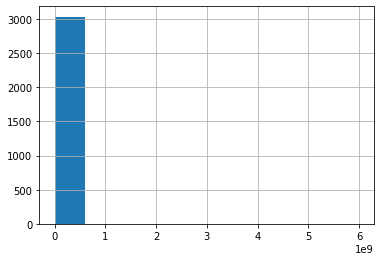

In [42]:
movies['budget'].hist()
plt.show()

Of all the financial features, `budget` is the most full. However, it has another issue. When we look at the histogram above, we see that nearly all of the films are put into one column. It is impossible to see with the human eye, but there are a very small number of films that have budgets that are exponentially greater than all the others, and these outliers are drawing out the scope of the x-axis.?

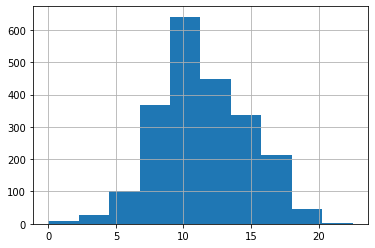

In [43]:
np.log(movies.loc[movies['budget'] != 0]['budget']).hist()

Using our pandas and numpy skills, we were able to convert this into a histogram that makes sense!

We thought of taking the log of the budget column, in order to deal with the outliers. However, we were reminded that one third of the budget variables are 0, which `np.log` sends to negative infinity. For the purposes of this histogram, we used `.loc` and a boolean mask to filter our data frame to only those records that reported a nonzero budget. 

The plot of this histogram is close to a normal distribution, which means we have at least sampled our data across a broad range of budgets, and these tend to a central value. 

This could be useful in developing a new feature that deals with classifying movies as `big budget` or `small budget`.

In [44]:
movies.loc[movies['budget'] != 0].describe()

,Year,runtime,budget,gross_usa,rating,star_3,writer_2,review_count,open_week,cumulative,...,Musical,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
count,2196.000000,2196.000000,2.196000e+03,2.196000e+03,2196.000000,360.0,1846.0,2196.000000,2.196000e+03,2.196000e+03,...,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.00000
mean,1971.186248,57.629326,1.105261e+07,5.033889e+06,27.188980,0.0,0.0,6143.841530,1.247548e+12,1.343292e+07,...,0.015483,0.051913,0.001366,0.061931,0.058743,0.009563,0.000455,0.167122,0.012295,0.00592
std,304.017179,51.913623,1.593580e+08,3.448138e+07,31.315214,0.0,0.0,35410.875805,1.039765e+13,9.293601e+07,...,0.123491,0.221901,0.036944,0.241085,0.235197,0.097343,0.021339,0.373170,0.110225,0.07673
min,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2018.000000,0.000000,1.000000e+04,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,2018.000000,74.500000,5.450000e+04,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,2018.000000,95.000000,1.000000e+06,0.000000e+00,59.000000,0.0,0.0,57.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,2020.000000,720.000000,6.000000e+09,7.000596e+08,95.000000,0.0,0.0,730792.000000,2.576982e+14,2.048360e+09,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Unfortunately, when we examine the dataframe that is filtered by having nonzero budget, hoping to find a denser data set, the statistics remain discouraging in their emptiness. 

While there are a few areas to explore, this data is largely unusable for any data mining solutions. We think that the data is so sparse because the large majority of the records we collected were not mainstream movies. Another factor that could affect this is the simple lack of accurate reporting for financial data on the website. For instance, we see that the max value in the `budget` columns is 6x10^9, that is, 6 billion dollars. The most expensive film budget of all time took no more than $379 million to make, so the figure in our data is either completely inaccurate, or quoted in a different currency. To not have invalid analysis, a check would have to be implemented to ensure that the currency is what we expect it to be, and when comparing across time, that numbers are inflation adjusted to be on the same scale. 

We will now try scraping a different data set that will hopefully be less sparse.

### TOP 250 Dataset

In [45]:
url = url_extractor('https://www.imdb.com/search/title/?groups=top_250')


250
Running query from 1 to 50
Running query from 51 to 100
Running query from 101 to 150
Running query from 151 to 200
Running query from 201 to 250
All urls have been extracted successfully


In [ ]:
movies = scraper(url)

In [ ]:
clean_movies = clean_data(movies)

encoded = encode_genre(clean_movies)

df_final2 = adjust_years(encoded)

In [ ]:
df_final.to_csv("df_top250.csv")

In [47]:
movies2 = pd.read_csv('df_top250.csv', index_col=0)
movies2.head()

,Year,country,language,production_co,runtime,budget,gross_usa,director_0,director_1,rating,...,Family,Fantasy,History,Music,Musical,Romance,Sci-Fi,Sport,Thriller,War
0,2019,USA,English,Tribeca Productions,209.0,159000000.0,0.0,Martin Scorsese,0,82.0,...,0,0,0,0,0,0,0,0,0,0
1,2019,USA,English,BRON Studios,122.0,55000000.0,332570374.0,Todd Phillips,0,87.0,...,0,0,0,0,0,0,0,0,1,0
2,2019,USA,English,Chernin Entertainment,152.0,97600000.0,94104794.0,James Mangold,0,83.0,...,0,0,0,0,0,0,0,1,0,0
3,2019,UK,English,Heyday Films,136.0,18600000.0,0.0,Noah Baumbach,0,83.0,...,0,0,0,0,0,1,0,0,0,0
4,2019,South Korea,Korean,Barunson E&A,132.0,0.0,19717719.0,Bong Joon Ho,0,86.0,...,0,0,0,0,0,0,0,0,1,0


This data set was collected from an IMDB search that returned the top 250 movies on IMDB by their metric of popularity. We hope that these movies correspond to movies that have highly reported and accurate data. Unfortunately, even in the best case this data will still not be useful for serious data mining or predictive analytics, because the number of instances is just too small. 

In [48]:
movies2.describe()

,Year,runtime,budget,gross_usa,rating,star_3,writer_2,review_count,open_week,cumulative,...,Family,Fantasy,History,Music,Musical,Romance,Sci-Fi,Sport,Thriller,War
count,250.000000,250.000000,2.500000e+02,2.500000e+02,250.000000,0.0,126.0,2.500000e+02,2.500000e+02,2.500000e+02,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,1987.248000,129.388000,9.247741e+07,7.825643e+07,83.028000,NaN,0.0,5.032167e+05,1.065979e+13,1.906968e+08,...,0.096000,0.084000,0.060000,0.036000,0.012000,0.104000,0.120000,0.040000,0.220000,0.100000
std,24.362772,34.331561,6.547530e+08,1.252663e+08,2.267993,NaN,0.0,4.315447e+05,3.565099e+13,3.344085e+08,...,0.295182,0.277944,0.237963,0.186664,0.109104,0.305873,0.325613,0.196352,0.415077,0.300602
min,1921.000000,0.000000,0.000000e+00,0.000000e+00,80.000000,NaN,0.0,2.626300e+04,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1972.000000,109.000000,2.000000e+06,5.629375e+05,81.000000,NaN,0.0,1.478168e+05,1.778754e+09,2.229591e+06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1994.000000,127.000000,1.125000e+07,2.345744e+07,82.000000,NaN,0.0,3.642120e+05,1.684667e+11,4.651521e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2006.750000,146.000000,3.725000e+07,1.020210e+08,84.000000,NaN,0.0,7.459690e+05,3.516386e+12,2.360023e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2019.000000,321.000000,1.000000e+10,8.583730e+08,93.000000,NaN,0.0,2.167336e+06,3.571150e+14,2.797801e+09,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see that our variables are much more inhabited!

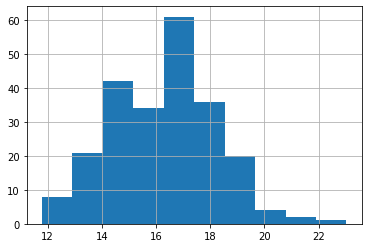

In [49]:
np.log(movies2.loc[movies2['budget']!=0]['budget']).hist()

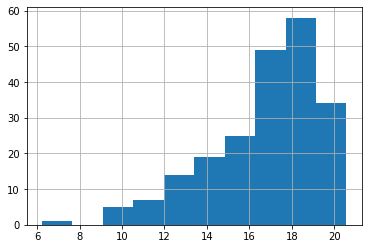

In [50]:
np.log(movies2.loc[movies2['gross_usa']!=0]['gross_usa']).hist()

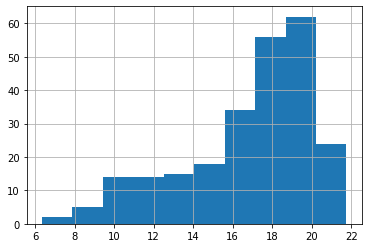

In [51]:
np.log(movies2.loc[movies2['cumulative']!=0]['cumulative']).hist()

Above, we notice that the histogram for `budget` has a similar shape to the previous data set. 

Interestingly, we find that histograms for `gross_usa` and `cumulative` earnings are unbalanced even after scaling with log. This is probably because the most popular movies on IMDB were also popular commercially, both in the USA and worldwide.

## Next Steps

### Our Code

When we pulled 6000 movies, the scraper took an hour and a half to run. This is because it was traversing one link at a time, pulling all the relevent information, and then moving on to the next. 

A way to speed up this process would be to implement some parallelization, perhaps through pyspark. This would allow the scraper to operate much faster. This could further be used to scrape a very large number of movies from IMDB, which we could then clean thoroughly to get only those movies that contain the data we might want to do analysis on. 

### The Dataset
Unfortunately, IMDB is missing a lot of the data we are interested in. But, if we were to find a way to scrape only those movies that are not missing a large number of key fields, there is more we could find.

In particular, exploration of director, actor, and writer as predictive variables of earnings would be an interesting project. A model that is able to look at an actor, director, writer combination, and predict the level of financial success to be expected could be useful for those in the film business.

One method we propose of doing this would require data bases for every director, actor, and writer in the sample of movies we look at. Based off of the success of their films and the length of their careers, these people could be classified into one of several categories that would be determined based on domain knowledge of the film industry. For example, one such category for a director might be 'veteran blockbuster director,' which would be based on a long career of directing big budget high earning movies. If all the personnel mentioned were binned into categories as such and subsequently one hot encoded, they could be used as variables in a machine learning solution.